# I. Introduction

This dataset is extracted from Fetal Health Classification on Kaggle (https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification).
In this script I try to go through Data Engineering, Feature Engineering, Feature Selection, model selection and validation.
I pay attention to pitfalls such as Data Leakage, Imbalanced Dataset and Bias-Accuracy trade-off.

Outlines:

* I. Introduction
* II. Data Engineering
* III. Outlier Detection
* IV. Data Mining
* V. Dimensionality reduction
    * V.A. T-SNE
    * V.B. PCA
    * V.C. Correlation between features 
* VI. Model Selection
    * VI.A. Neural Network
    * VI.B. XGBoost
* VII. Conclusion
* VIII. Acknowledgment

In [371]:
%reset
# Import the standard packages 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
import seaborn as sns
import os

In [372]:
# hard code the path
os.chdir(r'C:\Users\Ludov\OneDrive\Documents\20_12_22\Georgia_Tech\Kaggle')

In [373]:
#Read the csv dataset 
df_file = pd.read_csv('fetal_health.csv')

In [374]:
# Print the 5 first rows of the dataframe and explore the data
df_file.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


# II. Data Engineering

#### Check missing values and consistency of types with the variables

In [375]:
empty_val = [val_0 for col in df_file.columns for val_0 in df_file[col] if np.isnan(val_0)]
if np.isnan(empty_val).all()==True:
    print("CSV is full")
else : 
    print("Further process the input file")

CSV is full


In [376]:
# Display the types of the variables to check if they are consistent
df_file.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

In [377]:
# Check the number of variables to be sure no features need further data engineering, up or down sampling
df_file.count()

baseline value                                            2126
accelerations                                             2126
fetal_movement                                            2126
uterine_contractions                                      2126
light_decelerations                                       2126
severe_decelerations                                      2126
prolongued_decelerations                                  2126
abnormal_short_term_variability                           2126
mean_value_of_short_term_variability                      2126
percentage_of_time_with_abnormal_long_term_variability    2126
mean_value_of_long_term_variability                       2126
histogram_width                                           2126
histogram_min                                             2126
histogram_max                                             2126
histogram_number_of_peaks                                 2126
histogram_number_of_zeroes                             

### Check influence of variables on dataset

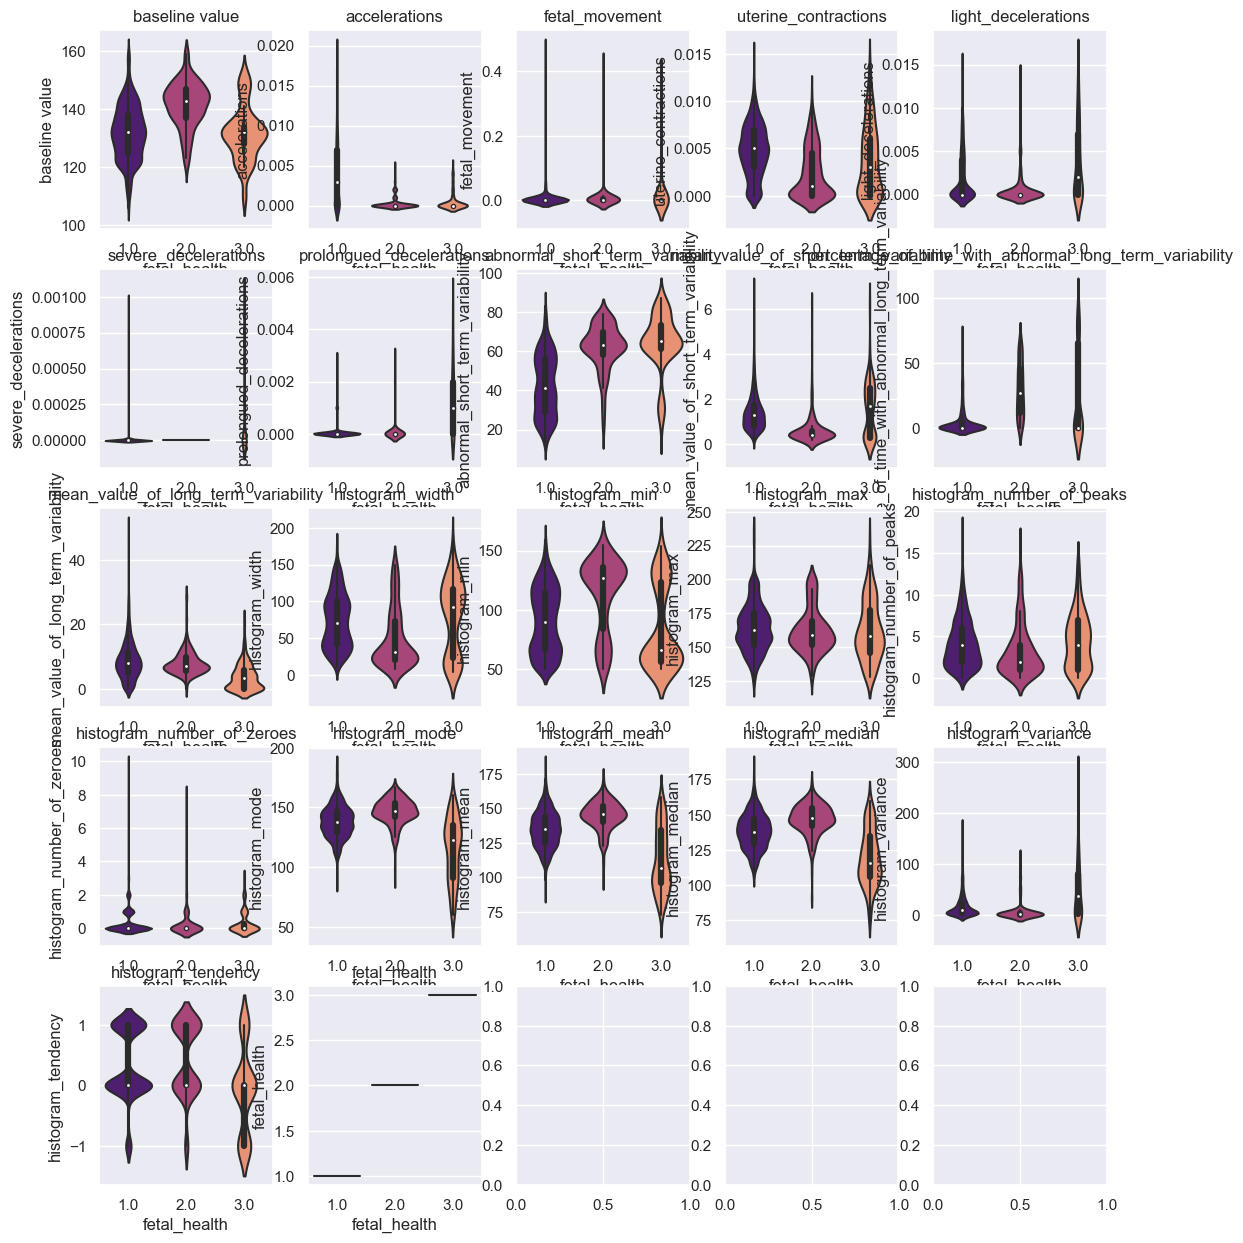

In [378]:
# Violin plots are adapted to visualize the distrbution of the data for each variables and classes.
n_rows = 5
n_cols = 5
count = 0
col_num = 0

plt.subplots(n_rows, n_cols, figsize=(13,15))
 
for i in range(n_rows):
    for j in range(n_cols):
        if col_num < df_file.shape[1] :
            
            plt.subplot(n_rows, n_cols, count+1), plt.title(df_file.columns[col_num])
            sns.violinplot(df_file, x='fetal_health', y=df_file.columns[col_num],  orient='vertical', palette="magma")
            
            count += 1
            col_num += 1

12 features are highly discriminative and we can see a lot of outliers on the violin plots.
The value ranges from very small to very large so we will need to normalize the features with StandardScaler.
We also detect that the dataset is highly imbalanced with 1 majority class >> *10 minority classes.
We will choose to neither up-sample nor down-sample but rather keeping the dataset like this. To avoid over-fitting the majority class and under-fitting the minority classes, we will then detect the outiers, perform feature engineering before runnning and comparing a nn model, a random forest and a xgboost.

# III. Outlier Detection

In [379]:
df_file.value_counts('fetal_health')

fetal_health
1.0    1655
2.0     295
3.0     176
dtype: int64

The dataset is imbalanced, fetal_health 1 represents 80% of the dataset, this is not a slight imbalance but a severe imbalance.
The results will be more sensitive to classification erros for minority class than majority class, see in confusion matrix.

* 1) Don't use accuracy with unbalanced dataset but rather:
Confusion matrix
Precision: Classifier exactness
Recall: Classifier completness 
F1-score: Weighted average of precision and recall
Kappa
ROC Curve

* 2) Generate synthetic data
Use SMOTE: Synthetic munority Over-sampling technique  in UnbalancedDataset module

* Numeric outlier: boxplot and get rid of out-of-range values
* Z-score: parametric techniques indicating how many standard deviation a certain point is from sample mean assuming a gaussian distribution. If not gaussian, transformation can make it look like a Bell curve, useful with medium/small dataset.
* DBScan: Clusterize the data in feature space into core, border and outlier points. Values need to be scaled and the model needs to be recalibrated if new data comes in the dataset, good to visualize and detect outliers.
* Isolation forest: works without scaling the values, but difficult to visualize.


# III.A. Outlier detection technique: Isolation Forest

In [380]:
from sklearn.ensemble import IsolationForest
# identifying outliers 
df_file = df_file.copy(deep=True)
iso = IsolationForest(random_state=0, contamination=0.05)# Fix the percentage of outliers detected with contamination
y_outliers = iso.fit_predict(df_file)

In [381]:
#Find score and anomaly value, columns are added to the df before being dropped out

df_file['scores'] = iso.decision_function(df_file)
df_file['anomaly_Value']= y_outliers
df_file.head() 

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,scores,anomaly_Value
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,0.038762,1
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,0.107917,1
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,0.093168,1
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,0.087703,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,0.093429,1


In [382]:
df_file[df_file["anomaly_Value"]== -1]
#Total percentage of outliers detected
df_file=pd.DataFrame(df_file)
print("Percentage of anomalies(outliers) in the dataset: {:.2f}".format((len(df_file.loc[df_file["anomaly_Value"]== -1])/len(df_file))*100))

Percentage of anomalies(outliers) in the dataset: 5.03


In [383]:
#droping outliers rows
for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        df_file.drop(i,inplace = True)

#checking new shape
df_file.shape

(2019, 24)

We can see that we reduced the number of rows with the isolation forest.

In [384]:
df_file.drop(columns=["scores","anomaly_Value"], inplace=True)

After identifying and removing the outliers, we are now left with classes that are easier to classify for a multi class classification algo. However, we still have 21 features. None of those are easily removable by hand so we need Feature Engineering. We will first try dimensionnality reduction with PCA and t-SNE to try finding a manifold which can represent the data and then regarding how it worked, we will rather perform Feature Selection regarding the correlation between the features.

# IV. Data Mining

#### Influences of features are different from one another

Let's plot the importance of each features on the dataset below. Once the dataset is splitted we can perform Feature Selection, not before because it leads to data leakage !

In [385]:
# We first select the variables and target 
X = df_file.drop("fetal_health", axis=1)

#label
y = df_file.loc[:, "fetal_health"]

In [386]:
# Then split the data into train and test set to avoid data leakage
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [387]:
# transform train input data

#loading all the sklearn modules I need
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

#mutual information selecting all features
mutual = SelectKBest(score_func=mutual_info_classif, k='all')

#learn relationship from training data
mutual.fit(X_train, y_train)

# transform train input data
X_train_mut = mutual.transform(X_train)


#printing scores of the features
for i in range(len(mutual.scores_)):
    print('Feature %d: %f' % (i, mutual.scores_[i]))

Feature 0: 0.107716
Feature 1: 0.144983
Feature 2: 0.032366
Feature 3: 0.067072
Feature 4: 0.029374
Feature 5: 0.000000
Feature 6: 0.057358
Feature 7: 0.186202
Feature 8: 0.226287
Feature 9: 0.201072
Feature 10: 0.046974
Feature 11: 0.109893
Feature 12: 0.103679
Feature 13: 0.073892
Feature 14: 0.034267
Feature 15: 0.000000
Feature 16: 0.096900
Feature 17: 0.124226
Feature 18: 0.089452
Feature 19: 0.127506
Feature 20: 0.012224


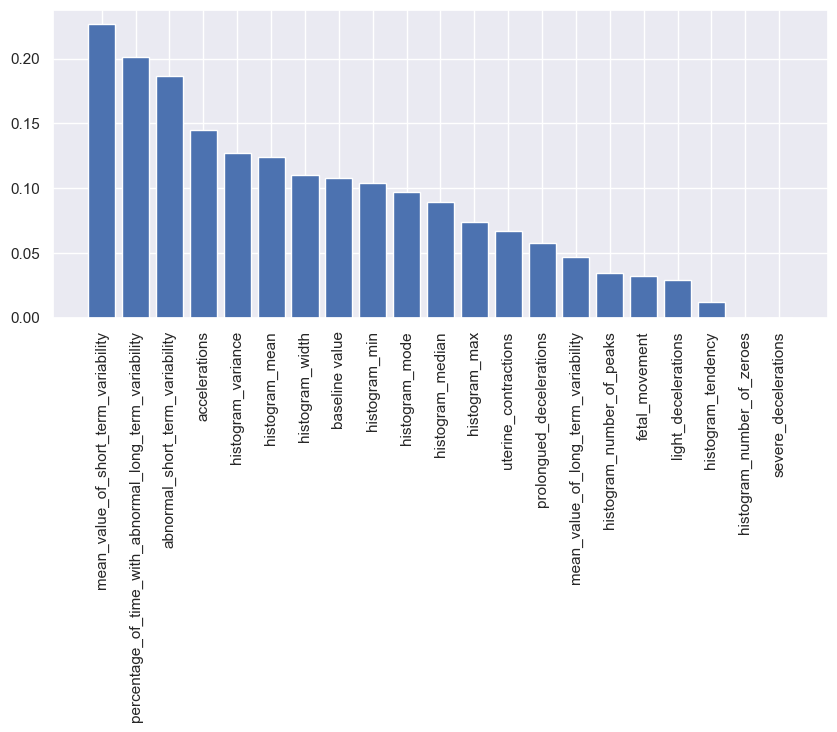

In [388]:
# We create a df with the test scores
mutual_score = pd.DataFrame(mutual.scores_, index=df_file.drop(columns=["fetal_health"]).columns, columns=["Mutual_Score"])
mutual_score = mutual_score.sort_values(by="Mutual_Score", ascending=False)

# We visualise with a bar graph which features are most influential
sns.set()
plt.figure(figsize=(10, 4))
plt.bar(x=mutual_score.index, height=mutual_score["Mutual_Score"])
plt.xticks(rotation=90)
plt.show()

We can see that few features describe well the dataset. It will be necesseray to identify which we can get rid of without loosing too much information in the dimensionality reduction and feature selection part below.

# V. Dimensionality reduction 

In order to diminish the complexity of the relationships in the dataset, we could perform dimensionality reduction. We will try 2 methods in the next steps. First, we will try PCA and then t-SNE.

To avoid Data Leakage, we perform dimensionality reduction on train set.

## V.A. T-SNE

In [389]:
from sklearn.manifold import TSNE

# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_iter sufficiently high to resolve the well stabilized cluster
# get embeddings
tsne_em = TSNE(n_components=2, perplexity=45.0, n_iter=1000, verbose=1).fit_transform(X_train)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 1615 samples in 0.001s...
[t-SNE] Computed neighbors for 1615 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1615
[t-SNE] Computed conditional probabilities for sample 1615 / 1615
[t-SNE] Mean sigma: 14.725862
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.492004
[t-SNE] KL divergence after 1000 iterations: 0.696157


<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

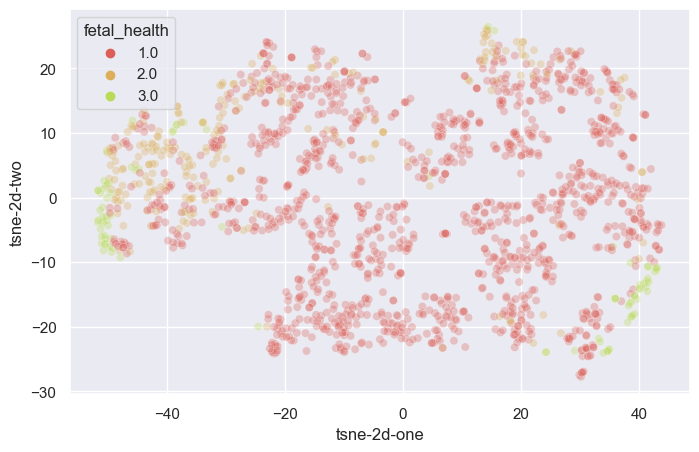

In [390]:
X_train['tsne-2d-one'] = tsne_em[:,0]
X_train['tsne-2d-two'] = tsne_em[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y,
    palette=sns.color_palette("hls", 10),
    data=X_train,
    legend="full",
    alpha=0.3
)

Some pattern is deteted with TSNE but data are still mixed up. Big problem is is unbalanced classes.

## V.B PCA

In [391]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train)

In [392]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.62121428 0.17375841]


In [393]:
X_train_PCA_df = pd.DataFrame(data = X_train_PCA
             , columns = ['principal component 1', 'principal component 2'])
X_train_PCA_df['y'] = y_train

In [394]:
X_train_PCA_df.head()

,principal component 1,principal component 2,y
0,-6.236385,61.764579,2.0
1,23.662849,17.862143,1.0
2,18.189286,-5.651522,1.0
3,72.004591,0.726801,NaN
4,12.795055,-5.903623,1.0


<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

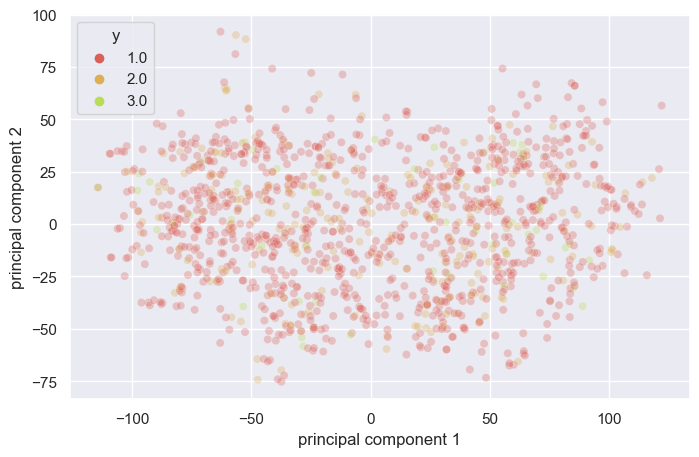

In [395]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_PCA_df,
    legend="full",
    alpha=0.3
)

Some pattern is deteted with PCA but data are still mixed up. Big problem is is unbalanced classes.
Is it surprising ? Let s plot the variance for each features and see if 2 are discriminative over the others.

In [396]:
pca = decomposition.PCA()
X_train_PCA = pca.fit_transform(X_train)

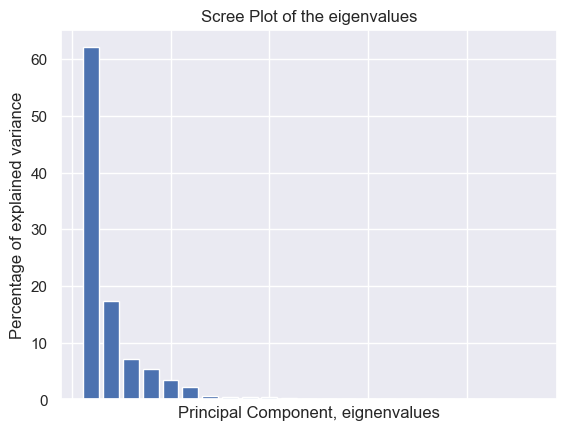

In [397]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Component, eignenvalues')
plt.title('Scree Plot of the eigenvalues')
plt.show()

We can see that 1 principal compenent is discriminative compared to the other but the 2nd principal component is not discriminative and the variance of the 2nd principal component is slightly higher than the 3rd and 4th.

We conclude the dimensionality reduction stating that, due to imbalanced dataset and complex relationship between features, PCA and t-SNE could not perform well in identifying few principal component.
We will rather try a more hands-on technics which is feature selection.

# V.C Correlation between features 

In [398]:
import plotly.express as px
fig = px.imshow(round(df_file.corr(),2), text_auto=True, title="Correlations between features",
                labels=dict(color="Correlation"), color_continuous_scale=px.colors.sequential.RdBu_r, 
                color_continuous_midpoint=0)
#Pearson's coefficient to study the covariance between features
fig.update_layout(autosize=False, width=1000, height=1000)
fig.show()

We see highly correlated featutes, some are highly linearly dependent so they will have the same effect on the labels.
We select the most correlated values 'baseline value', 'histogram_mode', 'histogram_median', 'histogram_mean', 'histogram_width', 'histogram_min', and we plot the distributions for those features below.

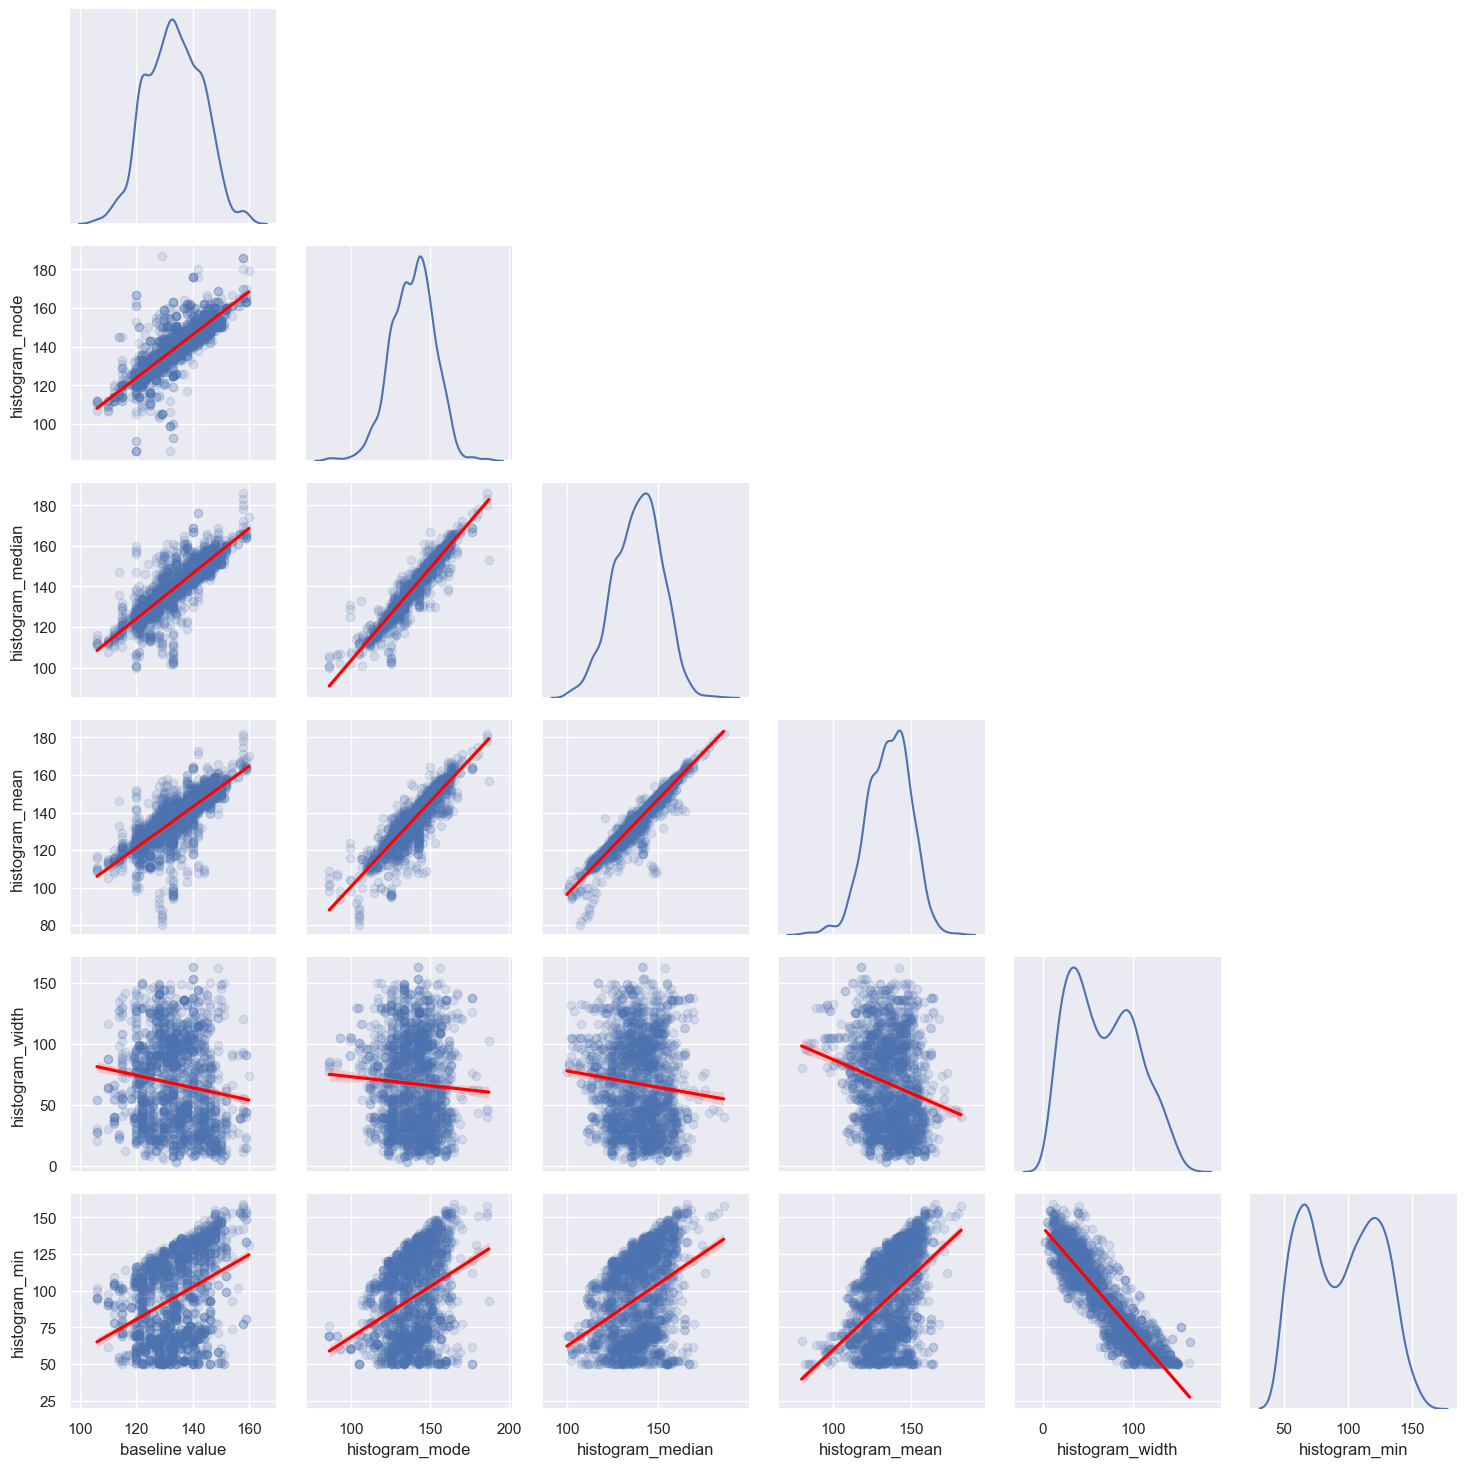

In [399]:
#creating a subtdataframe
subdf = df_file[['baseline value', 'histogram_mode', 'histogram_median', 'histogram_mean', 'histogram_width', 'histogram_min']]

#creating a unique plot with the regressions
g = sns.PairGrid(subdf,diag_sharey=False, corner=True)
g.map_offdiag(sns.regplot, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})
g.map_diag(sns.kdeplot)
plt.show()

This kind of plot allows to explore the relation between each features and to express the linear relationship between the features. If two features are highly correlated we only pick one of them because the other feature will add redundant information. Redundant information is not obviously more robust because it also add noise to the data. So it is better to reduce the dimensionnality, hence the number of feature of the datatset.

In [400]:
#droping the columns specified above
#Feature selection (fs) on the dataset according to PairGrid plot
df_file.drop(['histogram_mean', 'histogram_min'], axis=1, inplace=True)

#showing new shape
df_file.shape

(2019, 20)

# VI. Model Selection

## VI.A Neural Network

In [401]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

Transform y into dummy_variable in order to be used by keras

In [402]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [403]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[len(X_train.columns)]),
    layers.Dense(10, activation='relu'),    
    layers.Dense(3, activation='softmax'),    

])

We defined 3 layers with 10 neurons. The input layer has the salme length as the number of features in the dataset.

In [404]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [405]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0, 
)

Best Validation Loss: 0.3252
Best Validation Accuracy: 0.8827


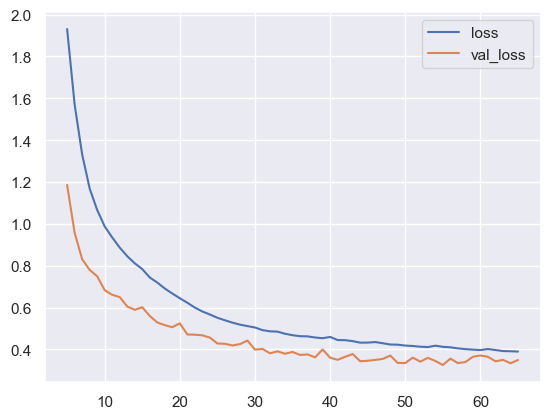

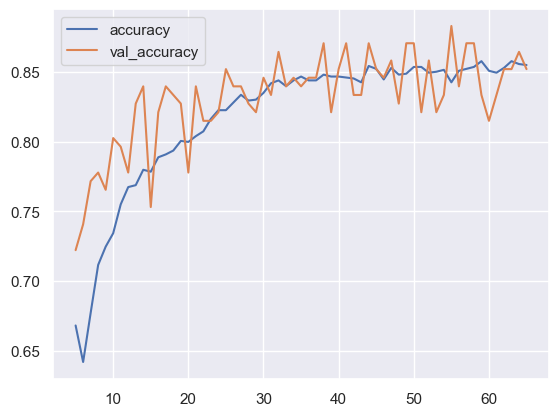

In [406]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

We can see that the loss diminishes and stabalizes and also that the accuracy grows but oscilates a lot. Regarding the highly imbalanced dataset, it is justified as accuracy is not a reliable metric with such dataset.

We now display how did the neural network performed. We display the confusion matrix regarding the test dataset and the predicted output.

13/13 [==============================] - 0s 1ms/step


<AxesSubplot: >

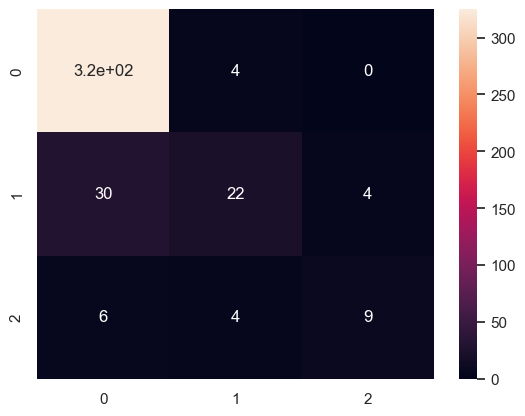

In [407]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
#One-hot-encoded so argmax needed as confusion matrix doesn't take vectors 
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), np.rint(y_pred.argmax(axis=1))), annot=True)


We can see that the neural network performed well as the classes are identified. To confirm, we plot the Kernel Density Estimate (kde plot).

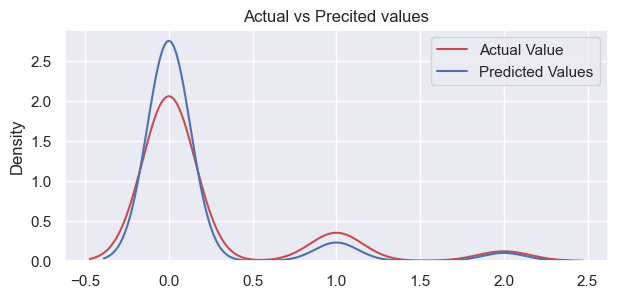

In [408]:
#figure size
plt.figure(figsize=(7, 3))

#Kernel Density Estimation plot
ax = sns.kdeplot(y_test.argmax(axis=1), color="r", label="Actual Value") #actual values
sns.kdeplot(y_pred.argmax(axis=1), color="b", label="Predicted Values", ax=ax) #predicted values

#showing title
plt.title('Actual vs Precited values')
#showing legend
plt.legend()
#showing plot
plt.show()

On the kde plot, we can see that the class 3 is well predicted but class 2 and 1 are not accurate.
Improvements could be to perform on KFold to check if this is a dataset issue or to try another multi-class classification method.
Next we will try identifying the classes with XGBoost.

# VI.B. XGBoost 

In [409]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split as split
import warnings
warnings.filterwarnings("ignore")
seed = 172

X_train, X_test, y_train, y_test = split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state= seed)
print(X_train.shape)
print(y_train.shape)

#normalizing features
scaler = StandardScaler() #calling the scaler 
#fitting the features to scale them
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(1615, 21)
(1615,)


Scale the data in order to have smaller values because algorithm performs better on smaller values

In [410]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.fit_transform(y_test)
import xgboost as xgb
from xgboost import XGBClassifier 
boost = XGBClassifier()
boost.fit(X_train, y_train, verbose=True)
p_boost = boost.predict(X_train)
print ("Score Train -->", round(boost.score(X_train, y_train) *100,2), " %")

Score Train --> 99.88  %


In [411]:
boost.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [412]:
#predictions and model accuracy
y_test_pred = boost.predict(X_test)
y_train_pred = boost.predict(X_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#accuracy
print('Model accuracy on test set: {}'.format(round(accuracy_score(y_test, y_test_pred),2)))
print('Model accuracy on training set: {}'.format(round(accuracy_score(y_train, y_train_pred),2)))

#precision
prec = precision_score(y_test, y_test_pred, average='weighted')
print('Model precision on test set: {}'.format(round(prec,2)))

#recall
rec = recall_score(y_test, y_test_pred, average='weighted')
print('Model recall on test set: {}'.format(round(rec,2)))

Model accuracy on test set: 0.95
Model accuracy on training set: 1.0
Model precision on test set: 0.95
Model recall on test set: 0.95


In [413]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(y_test_pred, y_test)))

Mean Absolute Error : 0.05693069306930693


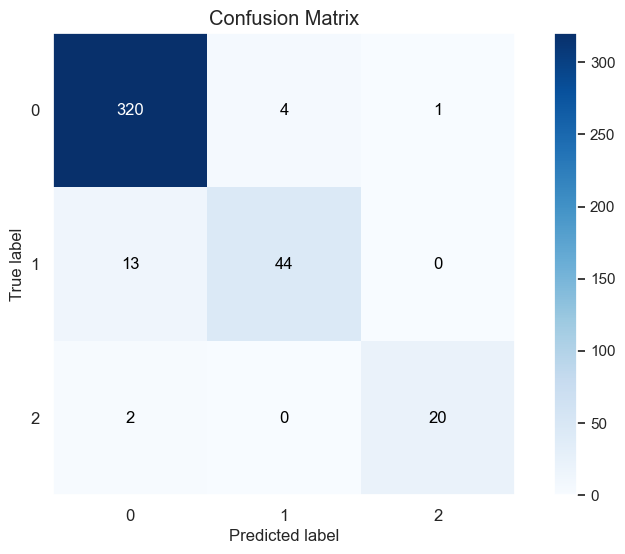

In [414]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, normalize=False, figsize=(10,6))
plt.show()

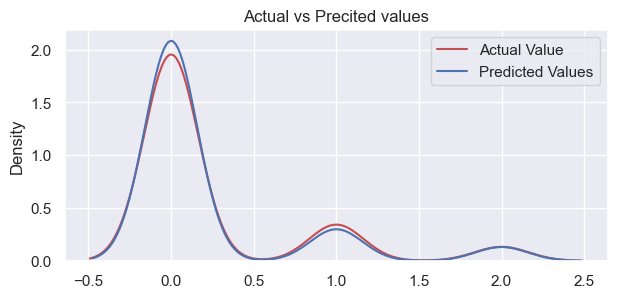

In [415]:
#figure size
plt.figure(figsize=(7, 3))

#Kernel Density Estimation plot
ax = sns.kdeplot(y_test, color="r", label="Actual Value") #actual values
sns.kdeplot(y_test_pred, color="b", label="Predicted Values", ax=ax) #predicted values

#showing title
plt.title('Actual vs Precited values')
#showing legend
plt.legend()
#showing plot
plt.show()

The confusion matrix of XGBoost is much more accurate. Precision and recall are also high.
Also the KDE plot show less discrepency in the results with more reliable actual vs. predicted values.
Still, there is a risk of overfitting and it should be tested through Kfold Cross validation.

# VII. Conclusion

For this dataset and mumti class classification, I would use XGBoost algorithm. The obtained results are hvery good and there is still way fro hyperparameters tuning.

# VIII. Acknowledgment
I adapted several algorithm in one to perform several aspect I wanted to takle in this dataset.

Credits:
[1] https://www.kaggle.com/code/cristianlapenta/fetal-health-classification-project
[2] https://www.reneshbedre.com/blog/tsne.html
[3] https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
